In [63]:
import numpy as np
import pandas as pd

from pprint import pprint

import copy

from tqdm.auto import tqdm

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares


from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics, MAP, MRR
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel
from rectools.model_selection import TimeRangeSplitter

In [123]:
df = pd.read_csv('data_original/interactions.csv', parse_dates=['last_watch_dt'])

df.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions = Interactions(df)


users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')


In [124]:
users[users['user_id'] == 666262]

,user_id,age,income,sex,kids_flg
373089,666262,age_65_inf,income_20_40,Ж,0


Функция для расчета метрик

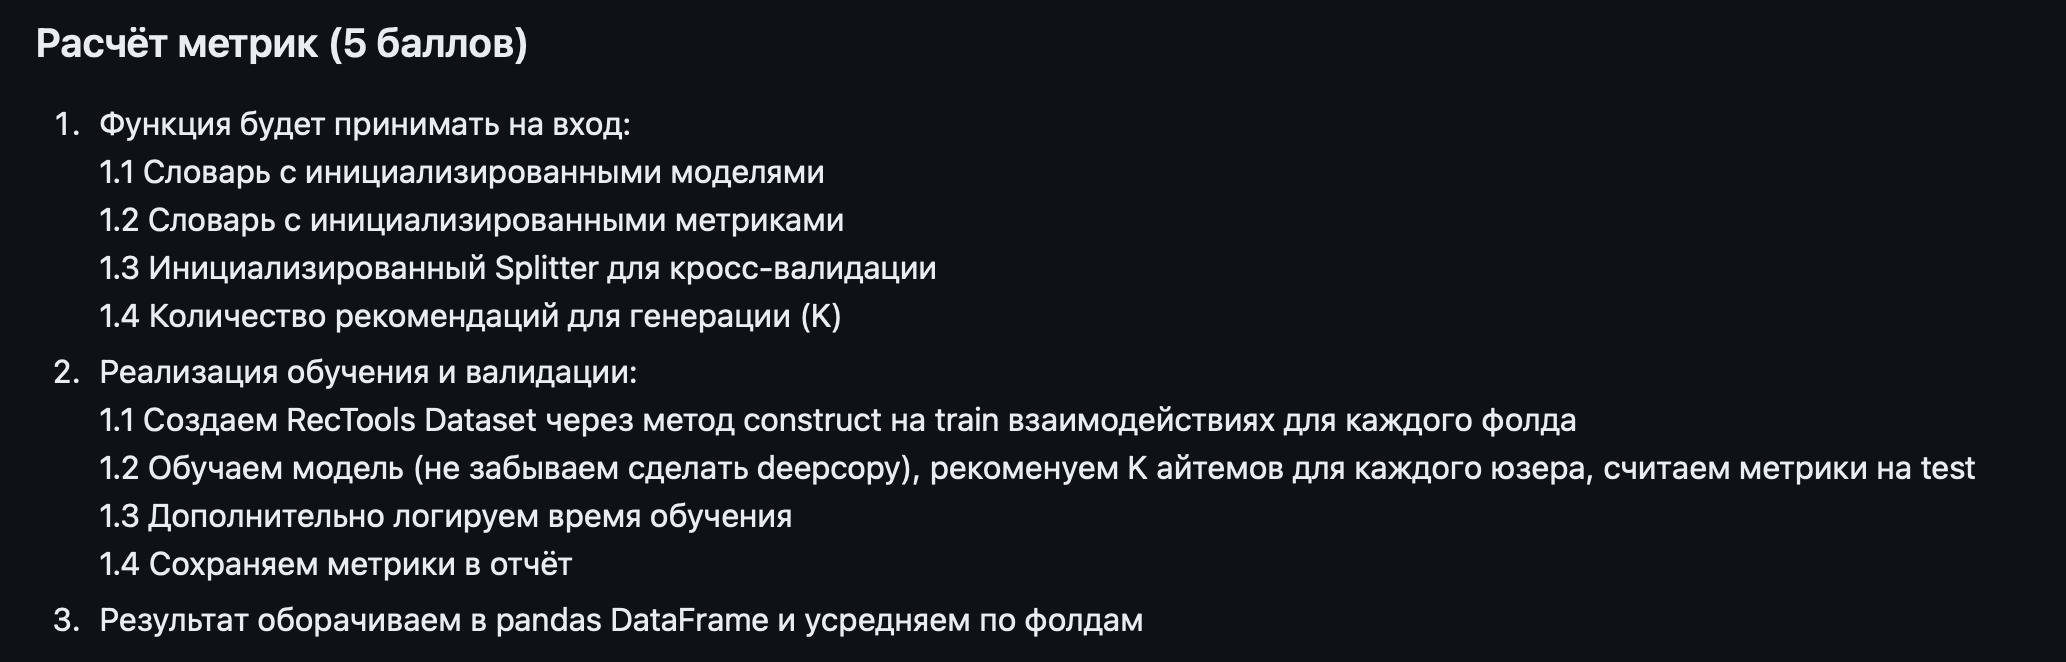

In [58]:
# Модели: rectools.models.RandomModel(random_state=32), rectools.models.PopularModel() с параметрами по умолчанию
models = {
    "random": RandomModel(random_state=32),
    "popular": PopularModel()
}

# Метрики: 2 ранжирующие, 2 классификационные, 2 beyond-accuracy. Считаем по порогам 1, 5, 10. MAP обязательно
metrics = {
    # классификационные
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=5),
    "prec@10": Precision(k=10),
    "recall": Recall(k=1),
    "recall": Recall(k=5),
    "recall": Recall(k=10),
    # ранжирующие
    "MAP": MAP(k=1),
    "MAP": MAP(k=5),
    "MAP": MAP(k=10),
    # среднее значение обратного ранга
    "MRR": MRR(k=1),
    "MRR": MRR(k=5),
    "MRR": MRR(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

# 3 фолда для кросс-валидации по неделе
n_splits = 3
test_size = "14D"

# Инициализированный Splitter для кросс-валидации
cv = TimeRangeSplitter(
    test_size= test_size,
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

# Количество рекомендаций для генерации (K)
K_RECOS = 10

In [ ]:
dataset = Dataset.construct(
            interactions_df=interactions,
            user_features_df=None,
            item_features_df=None,
        )



In [103]:
%%time
import time

def evaluate_models(interactions, models, metrics, cv, K_RECOS):
    results = []
    trained_models = {}

    # n_splits = cv.get_n_splits()
    fold_iterator = cv.split(interactions, collect_fold_stats=True)

    for train_ids, test_ids, fold_info in tqdm(fold_iterator, total=n_splits):
        print(f"\n==================== Fold {fold_info['i_split']}")
        pprint(fold_info)

        df_train = interactions.df.iloc[train_ids]
        # Создаем RecTools Dataset через метод construct на train взаимодействиях для каждого фолда
        dataset = Dataset.construct(df_train)
        # Определили test
        df_test = interactions.df.iloc[test_ids]  # Предполагается, что Columns.UserItem определено
        test_users = np.unique(df_test[Columns.User])

        catalog = df_train[Columns.Item].unique()  # Каталог для рекомендаций

        # Обучаем модель (не забываем сделать deepcopy), рекоменуем K айтемов для каждого юзера, считаем метрики на test
        for model_name, model in models.items():
            
            model_copy = copy.deepcopy(model)
            # время перед началом обучения
            start_time = time.time()
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=df_test,
                prev_interactions=df_train,
                catalog=catalog,
            )
            
            # время обучения
            training_time = time.time() - start_time

            res = {"fold": fold_info["i_split"], "model": model_name, "training_time": training_time}
            res.update(metric_values)
            results.append(res)

            # Сохраняем обученную модель
            if fold_info['i_split'] == n_splits - 1:  # Последний фолд
                trained_models[model_name] = model_copy
            

    # Результат оборачиваем в pandas DataFrame и усредняем по фолдам
    results_df = pd.DataFrame(results)
    average_results = results_df.groupby('model').mean()
    average_results = average_results.reset_index()
    return average_results, trained_models

# %%time
# df_rec, trained_models = evaluate_models(interactions, models, metrics, cv, K_RECOS)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 32.2 µs


In [104]:
%%time
df_rec, trained_models = evaluate_models(interactions, models, metrics, cv, K_RECOS)

  0%|          | 0/3 [00:00<?, ?it/s]


==================== Fold 0
{'end': Timestamp('2021-07-26 00:00:00'),
 'i_split': 0,
 'start': Timestamp('2021-07-12 00:00:00'),
 'test': 398993,
 'test_items': 7394,
 'test_users': 122488,
 'train': 3239125,
 'train_items': 14730,
 'train_users': 646423}


 33%|███▎      | 1/3 [00:17<00:35, 17.62s/it]


==================== Fold 1
{'end': Timestamp('2021-08-09 00:00:00'),
 'i_split': 1,
 'start': Timestamp('2021-07-26 00:00:00'),
 'test': 458757,
 'test_items': 7711,
 'test_users': 135624,
 'train': 3892558,
 'train_items': 15085,
 'train_users': 742256}


 67%|██████▋   | 2/3 [00:36<00:18, 18.27s/it]


==================== Fold 2
{'end': Timestamp('2021-08-23 00:00:00'),
 'i_split': 2,
 'start': Timestamp('2021-08-09 00:00:00'),
 'test': 521381,
 'test_items': 7705,
 'test_users': 151629,
 'train': 4649162,
 'train_items': 15415,
 'train_users': 850489}


100%|██████████| 3/3 [00:58<00:00, 19.50s/it]

CPU times: user 54 s, sys: 3.04 s, total: 57.1 s
Wall time: 58.5 s


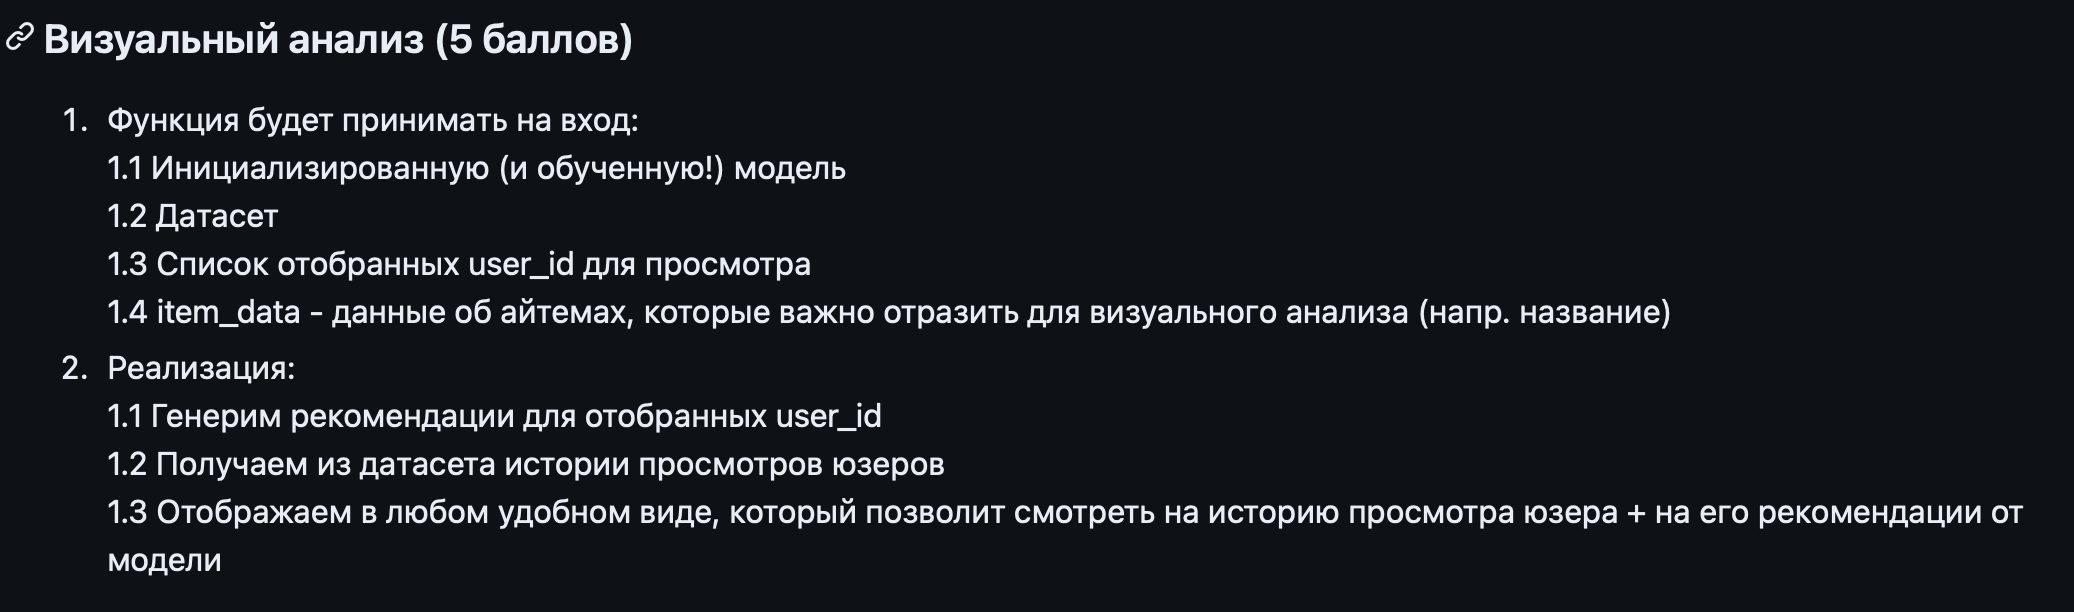

In [169]:
def reccomend(model, dataset, list_user, data, items):

    history_all = []
    recos_all = []

    for i in list_user:
        recos = model.recommend(
            users= df[Columns.User][df[Columns.User] == i].unique(),
            dataset=dataset,
            k=10,
            filter_viewed=True,
        )

        history_all.append(df[df['user_id'] == i].merge(users, how = 'left', on = 'user_id').merge(items, how = 'left', on = 'item_id'))
        recos_all.append(recos.merge(users, how = 'left', on = 'user_id').merge(items, how = 'left', on = 'item_id'))

    return history_all, recos_all

